<a href="https://colab.research.google.com/github/slipaway/melonplaylist/blob/%ED%98%84%EC%A3%BC/melon_kakao_eda_%EC%A0%9C%EB%AA%A9%EC%84%A4%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/kakao/khaiii.git
!pip install cmake
!mkdir build
!cd build && cmake /content/khaiii
!cd /content/build/ && make all
!cd /content/build/ && make resource
!cd /content/build && make install
!cd /content/build && make package_python
!pip install /content/build/package_python

Cloning into 'khaiii'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 957 (delta 25), reused 49 (delta 19), pack-reused 877
Receiving objects: 100% (957/957), 33.03 MiB | 10.36 MiB/s, done.
Resolving deltas: 100% (383/383), done.
-- [hunter] Initializing Hunter workspace (70287b1ffa810ee4e952052a9adff9b4856d0d54)
-- [hunter]   https://github.com/ruslo/hunter/archive/v0.23.34.tar.gz
-- [hunter]   -> /root/.hunter/_Base/Download/Hunter/0.23.34/70287b1
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import timedelta, datetime
import glob
import os
import re
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re
from collections import Counter
from typing import *
from khaiii import KhaiiiApi

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
folder = '/content/gdrive/My Drive/멜론 플레이리스트'
filelist = os.chdir(folder)

In [7]:
genre_gn_all=pd.read_json('genre_gn_all.json', typ='series')
train=pd.read_json('train.json')
val = pd.read_json('val.json')

In [ ]:
!git clone https://github.com/slipaway/melonplaylist.git

fatal: destination path 'melonplaylist' already exists and is not an empty directory.


# 0. 함수 정의

In [21]:
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

def uppertolower(string):
  if isEnglish(string) == True:
    string = string.lower() #태그나 제목이 영어로 들어간 경우, 모두 소문자로 바꿔주기

In [8]:
def re_sub(series: pd.Series) -> pd.Series:
  series = series.str.replace(pat=r'[ㄱ-ㅎ]', repl=r'', regex=True) #ㅋ 제거용
  series = series.str.replace(pat=r'[^\w\s]', repl=r'', regex=True) #특수문자 제거용
  series = series.str.replace(pat=r'[ ]{2,}', repl=r' ', regex=True) #공백 제거
  series = series.str.replace(pat=r'[\u3000]+', repl=r'', regex=True) #u3000제거
  return series

def flatten(list_of_list : List) -> List:
  flatten = [j for i in list_of_list for j in i]
  return flatten

def get_token(title: str, tokenizer)-> List[Tuple]:

  if len(title)==0 or title== ' ' : #제목이 공백인 경우 tokenizer 에러 발생
    return []
  
  result = tokenizer.analyze(title)
  result = [(morph.lex, morph.tag) for split in result for morph in split.morphs] # (형태소, 품사) 튜플의 리스트
  return result

def get_all_tags(df) -> List:
  tag_list = df['tags'].values.tolist()
  tag_list=flatten(tag_list)
  return tag_list

# 1. 태그 전처리

In [19]:
 train['tags'].head(10)

0                                                  [락]
1                                             [추억, 회상]
2                                            [까페, 잔잔한]
3    [연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...
4                                                 [댄스]
5    [운동, 드라이브, Pop, 트로피컬하우스, 힐링, 기분전환, 2017, 팝, 트렌...
6                          [짝사랑, 취향저격, 슬픔, 고백, 사랑, 이별]
7                                        [잔잔한, 추억, 회상]
8                          [일렉트로니카, 포크, 메탈, 락, 댄스, 인디]
9                   [록, Metal, 이일우, M에센셜, 메탈, Rock, 락]
Name: tags, dtype: object

In [9]:
tokenizer = KhaiiiApi()
all_tag = get_all_tags(train)
token_tag = [get_token(x, tokenizer) for x in all_tag] #태그를 형태소 분석

In [10]:
token_tag[:10]

[[('락', 'MAG')],
 [('추억', 'NNG')],
 [('회상', 'NNG')],
 [('까페', 'NNG')],
 [('잔잔', 'XR'), ('하', 'XSA'), ('ㄴ', 'ETM')],
 [('연말', 'NNG')],
 [('눈', 'NNG'), ('오', 'VV'), ('는', 'ETM'), ('날', 'NNG')],
 [('캐럴', 'NNG')],
 [('분위기', 'NNG')],
 [('따듯', 'XR'), ('하', 'XSA'), ('ㄴ', 'ETM')]]

In [11]:
token_itself=list(filter(lambda x: len(x)==1, token_tag)) # 태그 자체가 형태소여서 분리되지 않는 태그만 고름
token_itself=flatten(token_itself)
flatten_token=flatten(token_tag)

In [12]:
print('%-23s'%'# of original tag is', f'{len(all_tag):8,}')
print('%-23s'%'# of morpheme itself is', f'{len(token_itself):8,}')
print('%-23s'%'# of total token is', f'{len(flatten_token):8,}')

# of original tag is     476,331
# of morpheme itself is  333,093
# of total token is      722,860


In [13]:
#counting part of speech (pos)
pos=[x[1] for x in token_itself]
pos_count=Counter(pos)
popular_pos = pos_count.most_common()

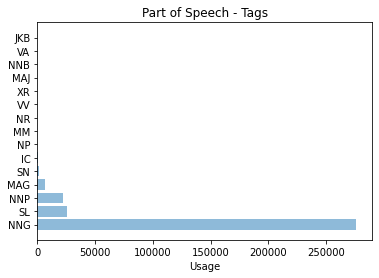

In [14]:
#tag 분류표
objects=[x[0] for x in popular_pos]
y_pos=np.arange(len(objects))
performance=[x[1] for x in popular_pos]

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Usage')
plt.title('Part of Speech - Tags')
plt.show()

# 2. 플레이리스트 제목 전처리

In [15]:
#플레이리스트 제목 형태소 분석

train['plylst_title']=re_sub(train['plylst_title'])
train.loc[:, 'ply_token']=train['plylst_title'].map(lambda x: get_token(x, tokenizer))

In [16]:
using_pos=['NNG', 'SL', 'NNP', 'MAG', 'SN'] #일반 명사, 외국어, 고유 명사, 일반 부사, 숫자
train['ply_token']=train['ply_token'].map(lambda x: list(filter(lambda x: x[1] in using_pos, x)))


In [17]:
unique_tag=set(token_itself)
unique_word=[x[0] for x in unique_tag]

#train 데이터의 plylst title 형태소 분리

In [18]:
#정답 tag에 나온 형태소만 남겨두기
train['ply_token']=train['ply_token'].map(lambda x: list(filter(lambda x: x[0] in unique_word, x)))
train.head(10)

,tags,id,plylst_title,songs,like_cnt,updt_date,ply_token
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,"[(여행, NNG), (음악, NNG)]"
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000,"[(요즘, NNG), (말, NNG)]"
2,"[까페, 잔잔한]",76951,편하게 잔잔하게 들을 수 있는 곡,"[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000,"[(곡, NNG)]"
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000,"[(크리스마스, NNG), (분위기, NNG), (흠뻑, MAG)]"
4,[댄스],27616,추억의 노래,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000,"[(추억, NNG), (노래, NNG)]"
5,"[운동, 드라이브, Pop, 트로피컬하우스, 힐링, 기분전환, 2017, 팝, 트렌...",69252,2017 Pop Trend,"[418694, 222305, 96545, 135950, 304687, 457451...",435,2017-09-15 15:59:26.000,"[(2017, SN), (Pop, SL)]"
6,"[짝사랑, 취향저격, 슬픔, 고백, 사랑, 이별]",45339,짝사랑고백사랑이별슬픔 감성을 자극하는곡들,"[528130, 505036, 398947, 627363, 37748, 376358...",24,2016-10-24 21:30:17.000,"[(짝사랑, NNG), (감성, NNG), (자극, NNG), (곡, NNG)]"
7,"[잔잔한, 추억, 회상]",36557,멍청이 내맘도 몰라,"[496913, 632529, 501426, 515574, 411161, 10341...",5,2008-09-23 22:32:02.000,"[(맘, NNG)]"
8,"[일렉트로니카, 포크, 메탈, 락, 댄스, 인디]",70741,DANCING IN THE MOONLIGHT 01,"[634861, 270738, 163936, 692209, 449477, 56342...",0,2019-11-30 21:17:59.000,"[(01, SN)]"
9,"[록, Metal, 이일우, M에센셜, 메탈, Rock, 락]",10288,록메탈 Written by 이일우,"[613315, 439294, 230806, 497932, 113479, 93506...",7,2016-06-17 18:23:54.000,"[(록메탈, NNP), (이일우, NNP)]"
